## Importing libraries and dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import f1_score

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate


import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
path = '/content/drive/My Drive/Data files for Colab/train.csv'
train = pd.read_csv(path)
train.drop('ID',inplace=True,axis=1)

Let us separate the feature and target matrix first. For features, we will only use the abstract based on the assumption that the title's words are largely paraphrased again in the abstract

In [4]:
labels = ['Computer Science', 'Physics', 'Mathematics','Statistics', 'Quantitative Biology', 'Quantitative Finance']

In [5]:
train['length'] = train['ABSTRACT'].apply(len)
train['total'] = train[labels].sum(axis=1)

## EDA

Majority of articles i.e. 40% belong to computer science followed by physics, mathematics and statistics between 20 to 30% of articles. Quantitative Biology and Quantiative Finance have fewer articles considering it is a niche field of study   

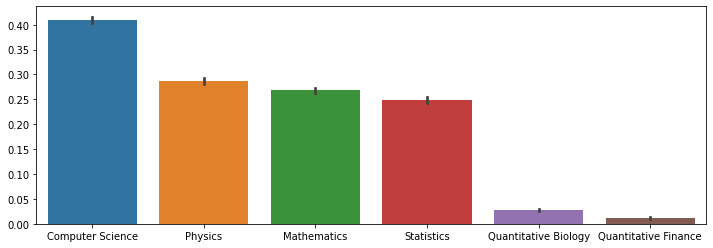

In [ ]:
plt.figure(figsize=(12,4))
sns.barplot(data=train[labels]);

Majority of the articles i.e. 16k out of 20k entries belong to only one category whereas fewer have 2 and 3 categories attributed to it

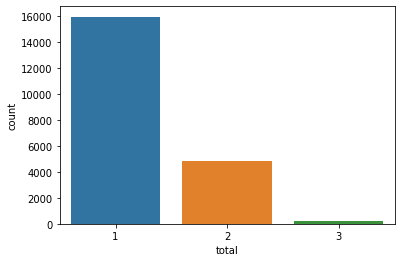

In [ ]:
sns.countplot(train['total']);

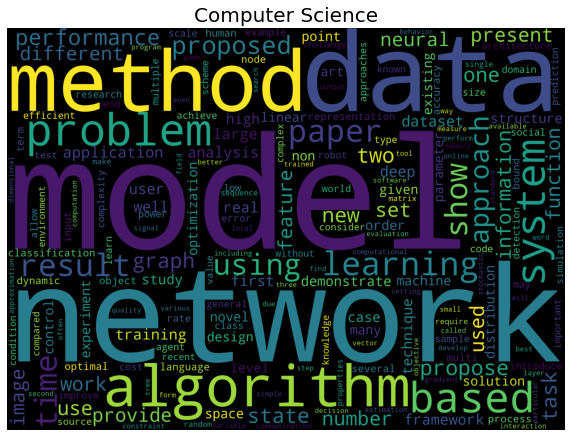

In [ ]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(10,10))
subset = train[train['Computer Science']==True]
text = subset['ABSTRACT'].values
cloud_cs = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("Computer Science",fontsize=20)
plt.imshow(cloud_cs);

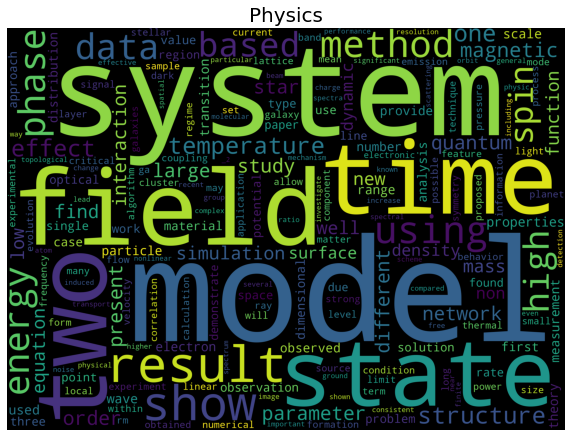

In [ ]:
plt.figure(figsize=(10,10))
subset = train[train['Physics']==True]
text = subset['ABSTRACT'].values
cloud_phy = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("Physics",fontsize=20)
plt.imshow(cloud_phy);

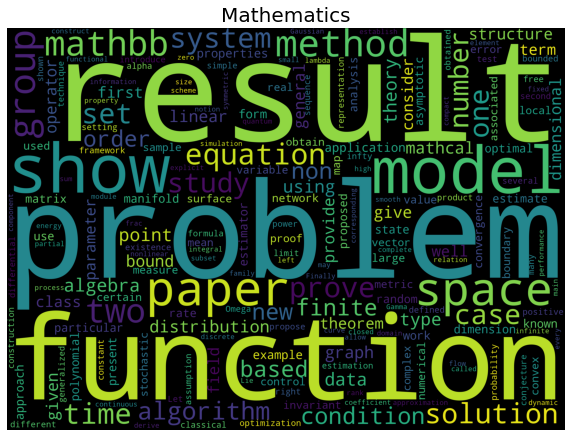

In [ ]:
plt.figure(figsize=(10,10))
subset = train[train['Mathematics']==True]
text = subset['ABSTRACT'].values
cloud_math = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("Mathematics",fontsize=20)
plt.imshow(cloud_math);

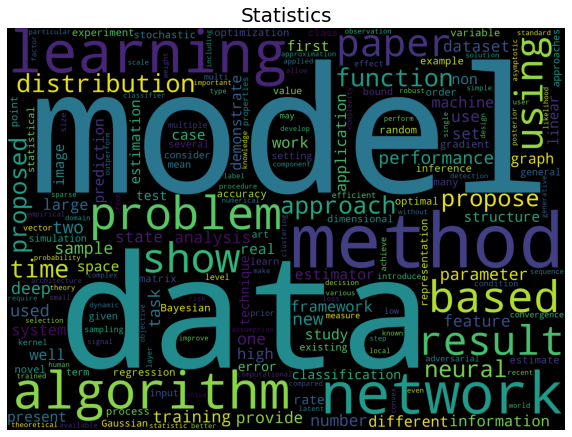

In [ ]:
plt.figure(figsize=(10,10))
subset = train[train['Statistics']==True]
text = subset['ABSTRACT'].values
cloud_stat = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("Statistics",fontsize=20)
plt.imshow(cloud_stat);

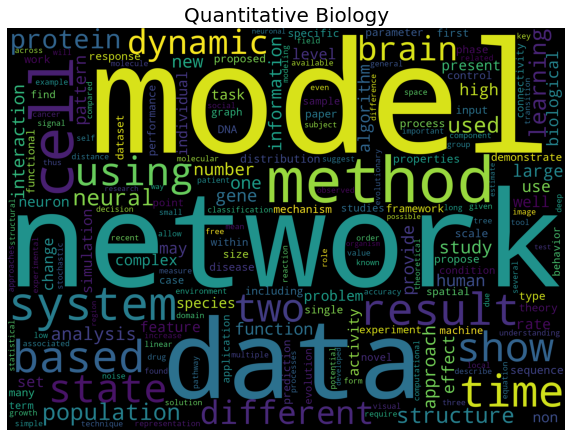

In [ ]:
plt.figure(figsize=(10,10))
subset = train[train['Quantitative Biology']==True]
text = subset['ABSTRACT'].values
cloud_qtbio = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("Quantitative Biology",fontsize=20)
plt.imshow(cloud_qtbio);

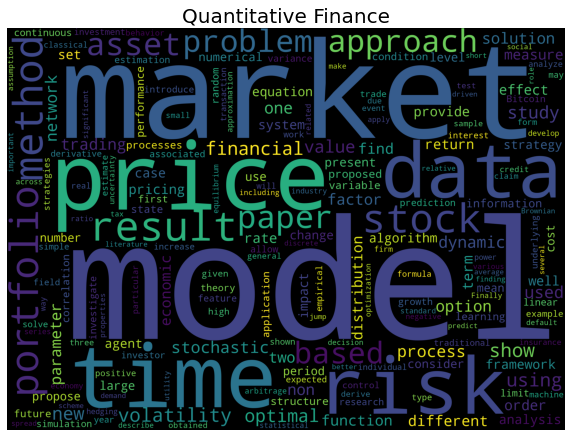

In [ ]:
plt.figure(figsize=(10,10))
subset = train[train['Quantitative Finance']==True]
text = subset['ABSTRACT'].values
cloud_qtfin = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        collocations=False,
                        width=2500,
                        height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("Quantitative Finance",fontsize=20)
plt.imshow(cloud_qtfin);

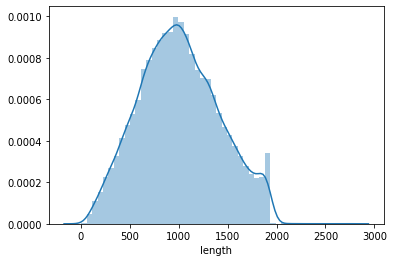

In [ ]:
sns.distplot(train['length']);

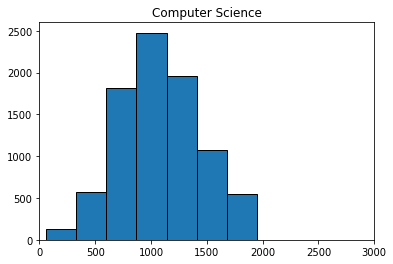

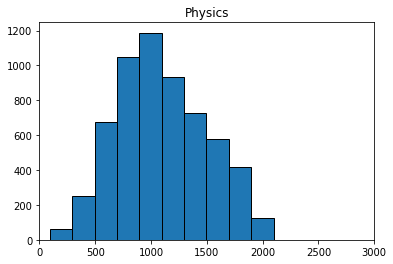

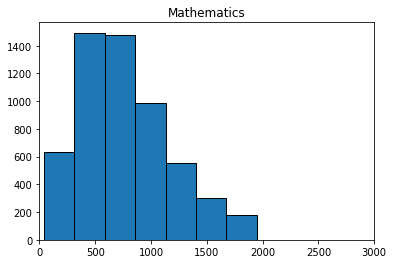

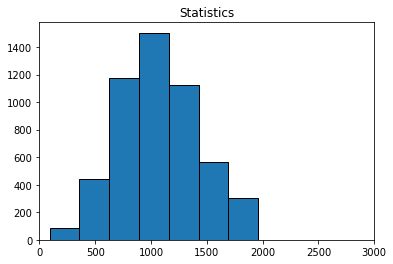

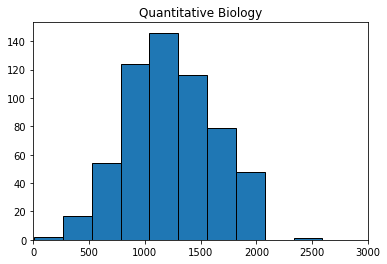

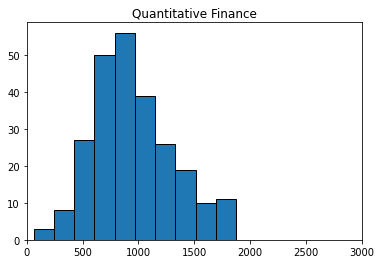

In [ ]:
for i in labels:
    plt.hist(train[train[i]==1]['length'],label=i,edgecolor='black')
    plt.xlim(0,3000)
    plt.title(i)
    plt.show()

## Doubling the observations for category 5 and 6 to improve model recall later while training  

In [6]:
y = train[labels].values

In [7]:
cat5 = []
cat6 = []
for i in range(0,len(y)):
  if y[i][4]==1:
    cat5.append(i) 
  if y[i][5]==1:
    cat6.append(i)

In [8]:
#Let us double the entries from category 5 and category 6 i.e. quantitative biology and quantiative finance to improve model recall
for i in cat5:
  train = pd.concat([train,pd.DataFrame(train.iloc[i]).transpose()])

In [9]:
for i in cat6:
  train = pd.concat([train,pd.DataFrame(train.iloc[i]).transpose()])

In [10]:
train.shape

(21808, 10)

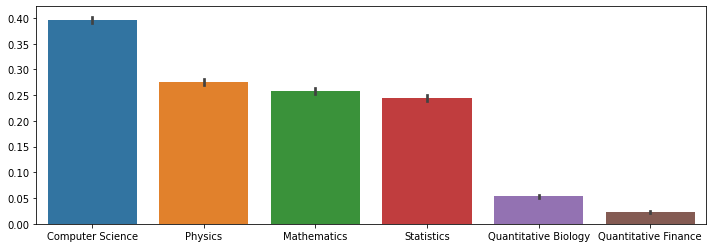

In [11]:
plt.figure(figsize=(12,4))
sns.barplot(data=train[labels]);

In [12]:
train.reset_index(drop=True,inplace=True)

In [19]:
X = train[['ABSTRACT','TITLE','length']]
y = train [labels].values
X.rename({'ABSTRACT' : 'Abstract_og'},axis=1,inplace=True)

In [21]:
X['ABSTRACT'] = X['Abstract_og'].str.cat(train['TITLE'], sep =" ") 

In [23]:
X.tail(1)

,Abstract_og,TITLE,length,ABSTRACT
21807,"Using a large-scale Deep Learning approach applied to a high-frequency\ndatabase containing billions of electronic market quotes and transactions for\nUS equities, we uncover nonparametric evidence for the existence of a universal\nand stationary price formation mechanism relating the dynamics of supply and\ndemand for a stock, as revealed through the order book, to subsequent\nvariations in its market price. We assess the model by testing its\nout-of-sample predictions for the direction of price moves given the history of\nprice and order flow, across a wide range of stocks and time periods. The\nuniversal price formation model is shown to exhibit a remarkably stable\nout-of-sample prediction accuracy across time, for a wide range of stocks from\ndifferent sectors. Interestingly, these results also hold for stocks which are\nnot part of the training sample, showing that the relations captured by the\nmodel are universal and not asset-specific.\nThe universal model --- trained on data from all stocks --- outperforms, in\nterms of out-of-sample prediction accuracy, asset-specific linear and nonlinear\nmodels trained on time series of any given stock, showing that the universal\nnature of price formation weighs in favour of pooling together financial data\nfrom various stocks, rather than designing asset- or sector-specific models as\ncommonly done. Standard data normalizations based on volatility, price level or\naverage spread, or partitioning the training data into sectors or categories\nsuch as large/small tick stocks, do not improve training results. On the other\nhand, inclusion of price and order flow history over many past observations is\nshown to improve forecasting performance, showing evidence of path-dependence\nin price dynamics.\n",Universal features of price formation in financial markets: perspectives from Deep Learning,1751,"Using a large-scale Deep Learning approach applied to a high-frequency\ndatabase containing billions of electronic market quotes and transactions for\nUS equities, we uncover nonparametric evidence for the existence of a universal\nand stationary price formation mechanism relating the dynamics of supply and\ndemand for a stock, as revealed through the order book, to subsequent\nvariations in its market price. We assess the model by testing its\nout-of-sample predictions for the direction of price moves given the history of\nprice and order flow, across a wide range of stocks and time periods. The\nuniversal price formation model is shown to exhibit a remarkably stable\nout-of-sample prediction accuracy across time, for a wide range of stocks from\ndifferent sectors. Interestingly, these results also hold for stocks which are\nnot part of the training sample, showing that the relations captured by the\nmodel are universal and not asset-specific.\nThe universal model --- trained on data from all stocks --- outperforms, in\nterms of out-of-sample prediction accuracy, asset-specific linear and nonlinear\nmodels trained on time series of any given stock, showing that the universal\nnature of price formation weighs in favour of pooling together financial data\nfrom various stocks, rather than designing asset- or sector-specific models as\ncommonly done. Standard data normalizations based on volatility, price level or\naverage spread, or partitioning the training data into sectors or categories\nsuch as large/small tick stocks, do not improve training results. On the other\nhand, inclusion of price and order flow history over many past observations is\nshown to improve forecasting performance, showing evidence of path-dependence\nin price dynamics.\n Universal features of price formation in financial markets: perspectives from Deep Learning"


## BERT Implementation

In [87]:
abstract = train ['ABSTRACT'].values
# label = train [labels].values

In [88]:
#Using colab GPU
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [89]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla K80


In [90]:
#installing hugging face library (now called as transformers)

!pip install transformers

In [91]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


### BERT Tokenizer

In [92]:
#Applying Bert Tokenizer to just one abstract 

# Print the original sentence.
print(' Original: ', abstract[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(abstract[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(abstract[0])))

# Print the length of token
print('Length of tokens extracted', len(tokenizer.tokenize(abstract[0])))

 Original:    Predictive models allow subject-specific inference when analyzing disease
related alterations in neuroimaging data. Given a subject's data, inference can
be made at two levels: global, i.e. identifiying condition presence for the
subject, and local, i.e. detecting condition effect on each individual
measurement extracted from the subject's data. While global inference is widely
used, local inference, which can be used to form subject-specific effect maps,
is rarely used because existing models often yield noisy detections composed of
dispersed isolated islands. In this article, we propose a reconstruction
method, named RSM, to improve subject-specific detections of predictive
modeling approaches and in particular, binary classifiers. RSM specifically
aims to reduce noise due to sampling error associated with using a finite
sample of examples to train classifiers. The proposed method is a wrapper-type
algorithm that can be used with different binary classifiers in a diagno

In [93]:
#Tokenize all of the sentences and map the tokens to their word IDs
input_ids = []

#Record the length of each sequence (after truncating to 512)
lengths = []

for sen in abstract:
  if (len(input_ids) % 20000 ) == 0:
    print('Read {:,} comments'.format(len(input_ids)))

  #encode will 
  # (1) tokenize the sentence
  # (2) prepend 'CLS' token to the start
  # (3) append the 'SEP' token at the end
  # (4) map tokens to their IDs
  encoded_sent = tokenizer.encode(sen,add_special_tokens=True,
                                  # max length = 512,
                                  # return_tensors = 'pt' #returns pytorch tensors
                                  )
  
  #add the encoded sentence to the list
  input_ids.append(encoded_sent)

  #record the truncated length
  lengths.append(len(encoded_sent))

print('DONE')
print('')

Read 0 comments


Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (514 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (582 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (532 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Read 20,000 comments


Token indices sequence length is longer than the specified maximum sequence length for this model (511 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (714 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (581 > 512). Running this sequence through the model will result in indexing errors


DONE



In [94]:
#Let's grab some quick stats about the abstract lengths that we have

print('    Min length:  {:,} tokens'.format(min(lengths)))
print('    Max length:  {:,} tokens'.format(max(lengths)))
print(' Median length:  {:,} tokens'.format(np.median(lengths)))

    Min length:  4 tokens
    Max length:  933 tokens
 Median length:  201.0 tokens


So our median length is much lower than BERT's allowed 512 tokens. So later we will only have to truncate the very few tokens that are above this 512 limit

Text(0, 0.5, '# of Abstracts')

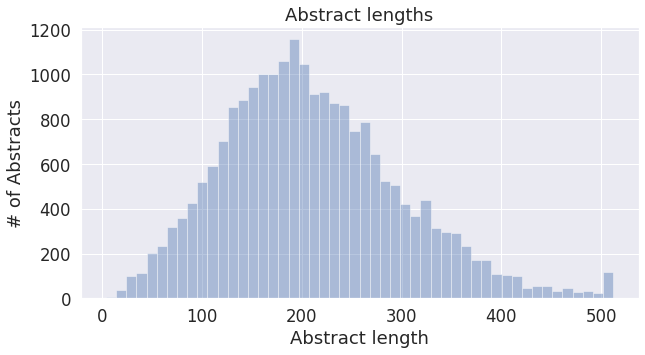

In [95]:
#Plotting the abstract length v/s the token lengths
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (10,5)

#Let us truncate all lengths above 512 to 512
lengths = [min(l,512) for l in lengths]

sns.distplot(lengths,kde=False,rug=False)

plt.title('Abstract lengths')
plt.xlabel('Abstract length')
plt.ylabel('# of Abstracts')

In [96]:
#Count the number of sentences that had to be truncated to tokens
num_truncated = lengths.count(512)

#Compare this to the total number of training sentences
num_abstracts = len(lengths)
prcnt = float(num_truncated)/float(num_abstracts)

print(' {:,} of {:,} abstracts ({: .1%}) in the training set are longer than 512 tokens'.format(
    num_truncated, num_abstracts, prcnt
))

 99 of 21,808 abstracts ( 0.5%) in the training set are longer than 512 tokens


In [97]:
# Only 0.5% of abstract submissions are above 512 token size. So now let us truncate all these abstracts 

from keras.preprocessing.sequence import pad_sequences
max_len = 200

print('Padding/truncating all sentences to %d values..' % max_len)

#pad our input tokens with value 0.
input_ids = pad_sequences(input_ids,
                          maxlen=max_len,
                          dtype='long',
                          value=0,
                          truncating='post',
                          padding='post')

print('Done')

Padding/truncating all sentences to 200 values..
Done


In [98]:
# Adding attention masks to differentiate between actual words and paddings

attention_masks = []

for sent in input_ids:
  # Create the attention mask
  # if a token_id is 0, then it's padding, set the mask to 0
  # if a token_id is 1, then it's a real token, set the mask to 1
  
  att_mask = [int(token_id > 0) for token_id in sent]

  # store the attention mask for this abstract
  attention_masks.append(att_mask)

### Training & Validation split

In [99]:
train_df = train[labels]

In [100]:
train_df["features"] = input_ids.tolist()
train_df["masks"] = attention_masks

In [101]:
train_df.head(1)

,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance,features,masks
0,1,0,0,0,0,0,"[101, 16014, 3512, 4275, 3499, 3395, 1011, 3563, 28937, 2043, 20253, 4295, 3141, 16705, 1999, 11265, 10976, 9581, 4726, 2951, 1012, 2445, 1037, 3395, 1005, 1055, 2951, 1010, 28937, 2064, 2022, 2081, 2012, 2048, 3798, 1024, 3795, 1010, 1045, 1012, 1041, 1012, 8909, 4765, 10128, 28008, 2075, 4650, 3739, 2005, 1996, 3395, 1010, 1998, 2334, 1010, 1045, 1012, 1041, 1012, 25952, 4650, 3466, 2006, 2169, 3265, 10903, 15901, 2013, 1996, 3395, 1005, 1055, 2951, 1012, 2096, 3795, 28937, 2003, 4235, 2109, 1010, 2334, 28937, 1010, 2029, 2064, 2022, 2109, 2000, 2433, 3395, 1011, 3563, 3466, 7341, 1010, 2003, 6524, 2109, ...]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...]"


In [102]:
# train valid split
train, valid = train_test_split(train_df, test_size=0.4, random_state=2020)

In [103]:
train_inputs = train["features"].values.tolist()
validation_inputs = valid["features"].values.tolist()

train_masks = train["masks"].values.tolist()
validation_masks = valid["masks"].values.tolist()

train_labels = train[labels].values.tolist()
validation_labels = valid[labels].values.tolist()

In [104]:
# from sklearn.model_selection import train_test_split

# train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids,
#                                                                                     label,
#                                                                                     random_state=2020,
#                                                                                     test_size=0.1)

# #Similarly for the masks
# train_masks, validation_masks, _, _ = train_test_split(attention_masks,label,random_state=2020,
#                                                        test_size=0.1)

In [105]:
# Convert all arrays to torch tensors which is the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels, dtype=torch.float32)
validation_labels = torch.tensor(validation_labels, dtype=torch.float32)

train_masks = torch.tensor(train_masks, dtype = torch.long)
validation_masks = torch.tensor(validation_masks, dtype = torch.long)

### Bert fine-tuning

In [131]:
!pip install pytorch_pretrained_bert

     |████████████████████████████████| 133kB 6.9MB/s 


In [133]:
!pip install apex

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 716kB 18.5MB/s 
     |████████████████████████████████| 327kB 38.2MB/s 
     |████████████████████████████████| 174kB 39.2MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 235kB 36.2MB/s 
     |████████████████████████████████| 143kB 36.8MB/s 
     |████████████████████████████████| 122kB 41.1MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
  Created wheel for cryptacular: filename=cryptacular-1.5.5-cp36-abi3-manylinux2010_x86_64.whl size=47560 sha256=474850d44f66bac15e6b1770ea9e9ce62839b22b62caee6d762581fe5c033dc8
  Stored in directory: /root/.cache/pip/wheels/3c/79/bc/1eec7120c3ff9b0a2c7ad94d1626abc3388688e2ed7a45878f
Successfully built cryptacular
  Created wheel for apex: filename=apex-0.9.10.dev0-cp36-none-any.whl size=46467 sha256=933302dcc6949560eff59f707b

In [139]:
import logging
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)
logger = logging.getLogger(__name__)

In [143]:
DATA_PATH=Path('/content/drive/My Drive/Data files for Colab/')
DATA_PATH.mkdir(exist_ok=True)

PATH=Path('/content/drive/My Drive/Data files for Colab/')
PATH.mkdir(exist_ok=True)

CLAS_DATA_PATH=PATH/'class'
CLAS_DATA_PATH.mkdir(exist_ok=True)

model_state_dict = None

BERT_PRETRAINED_PATH = Path('/content/drive/My Drive/Data files for Colab/uncased_L-12_H-768_A-12/')
PYTORCH_PRETRAINED_BERT_CACHE = BERT_PRETRAINED_PATH/'cache/'
PYTORCH_PRETRAINED_BERT_CACHE.mkdir(exist_ok=True)

In [144]:
from pytorch_pretrained_bert.tokenization import BertTokenizer, WordpieceTokenizer
from pytorch_pretrained_bert.modeling import BertForPreTraining, BertPreTrainedModel, BertModel, BertConfig, BertForMaskedLM, BertForSequenceClassification
from pathlib import Path
import torch
import re
from torch import Tensor
from torch.nn import BCEWithLogitsLoss
from fastai.text import Tokenizer, Vocab
import pandas as pd
import collections
import os
import pdb
from tqdm import tqdm, trange
import sys
import random
import numpy as np
# import apex
from sklearn.model_selection import train_test_split
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from sklearn.metrics import roc_curve, auc


from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler
from pytorch_pretrained_bert.optimization import BertAdam

In [145]:
#Model parameters
args = {
    "train_size": -1,
    "val_size": -1,
    "full_data_dir": DATA_PATH,
    "data_dir": PATH,
    "task_name": "toxic_multilabel",
    "no_cuda": False,
    "bert_model": BERT_PRETRAINED_PATH,
    "output_dir": CLAS_DATA_PATH/'output',
    "max_seq_length": 512,
    "do_train": True,
    "do_eval": True,
    "do_lower_case": True,
    "train_batch_size": 32,
    "eval_batch_size": 32,
    "learning_rate": 3e-5,
    "num_train_epochs": 4.0,
    "warmup_proportion": 0.1,
    "no_cuda": False,
    "local_rank": -1,
    "seed": 42,
    "gradient_accumulation_steps": 1,
    "optimize_on_cpu": False,
    "fp16": False,
    "loss_scale": 128
}

In [147]:
class BertForMultiLabelSequenceClassification(BertPreTrainedModel):
    """BERT model for classification.
    This module is composed of the BERT model with a linear layer on top of
    the pooled output.
    """
    def __init__(self, config, num_labels=2):
        super(BertForMultiLabelSequenceClassification, self).__init__(config)
        self.num_labels = num_labels
        self.bert = BertModel(config)
        self.dropout = torch.nn.Dropout(config.hidden_dropout_prob)
        self.classifier = torch.nn.Linear(config.hidden_size, num_labels)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        _, pooled_output = self.bert(input_ids, token_type_ids, attention_mask, output_all_encoded_layers=False)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        if labels is not None:
            loss_fct = BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1, self.num_labels))
            return loss
        else:
            return logits
        
    def freeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = False
    
    def unfreeze_bert_encoder(self):
        for param in self.bert.parameters():
            param.requires_grad = True


In [148]:
class InputExample(object):
    """A single training/test example for sequence classification."""

    def __init__(self, guid, text_a, text_b=None, labels=None):
        """Constructs a InputExample.
        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            labels: (Optional) [string]. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.labels = labels

In [149]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_ids):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_ids = label_ids

In [150]:
class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()
    
    def get_test_examples(self, data_dir, data_file_name, size=-1):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError() 

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

In [151]:
class MultiLabelTextProcessor(DataProcessor):
    
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.labels = None
    
    
    def get_train_examples(self, data_dir, size=-1):
        filename = 'train.csv'
        logger.info("LOOKING AT {}".format(os.path.join(data_dir, filename)))
        if size == -1:
            data_df = pd.read_csv(os.path.join(data_dir, filename))
#             data_df['comment_text'] = data_df['comment_text'].apply(cleanHtml)
            return self._create_examples(data_df, "train")
        else:
            data_df = pd.read_csv(os.path.join(data_dir, filename))
#             data_df['comment_text'] = data_df['comment_text'].apply(cleanHtml)
            return self._create_examples(data_df.sample(size), "train")
        
    def get_dev_examples(self, data_dir, size=-1):
        """See base class."""
        filename = 'val.csv'
        if size == -1:
            data_df = pd.read_csv(os.path.join(data_dir, filename))
#             data_df['comment_text'] = data_df['comment_text'].apply(cleanHtml)
            return self._create_examples(data_df, "dev")
        else:
            data_df = pd.read_csv(os.path.join(data_dir, filename))
#             data_df['comment_text'] = data_df['comment_text'].apply(cleanHtml)
            return self._create_examples(data_df.sample(size), "dev")
    
    def get_test_examples(self, data_dir, data_file_name, size=-1):
        data_df = pd.read_csv(os.path.join(data_dir, data_file_name))
#         data_df['comment_text'] = data_df['comment_text'].apply(cleanHtml)
        if size == -1:
            return self._create_examples(data_df, "test")
        else:
            return self._create_examples(data_df.sample(size), "test")

    def get_labels(self):
        """See base class."""
        if self.labels == None:
            self.labels = list(pd.read_csv(os.path.join(self.data_dir, "classes.txt"),header=None)[0].values)
        return self.labels

    def _create_examples(self, df, set_type, labels_available=True):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, row) in enumerate(df.values):
            guid = row[0]
            text_a = row[1]
            if labels_available:
                labels = row[2:]
            else:
                labels = []
            examples.append(
                InputExample(guid=guid, text_a=text_a, labels=labels))
        return examples

In [152]:
def convert_examples_to_features(examples, label_list, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""

    label_map = {label : i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens += tokens_b + ["[SEP]"]
            segment_ids += [1] * (len(tokens_b) + 1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length
        
        labels_ids = []
        for label in example.labels:
            labels_ids.append(float(label))

#         label_id = label_map[example.label]
        if ex_index < 0:
            logger.info("*** Example ***")
            logger.info("guid: %s" % (example.guid))
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            logger.info("label: %s (id = %s)" % (example.labels, labels_ids))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_ids=labels_ids))
    return features

In [153]:
def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

In [154]:
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs == labels)

def accuracy_thresh(y_pred:Tensor, y_true:Tensor, thresh:float=0.5, sigmoid:bool=True):
    "Compute accuracy when `y_pred` and `y_true` are the same size."
    if sigmoid: y_pred = y_pred.sigmoid()
#     return ((y_pred>thresh)==y_true.byte()).float().mean().item()
    return np.mean(((y_pred>thresh)==y_true.byte()).float().cpu().numpy(), axis=1).sum()


def fbeta(y_pred:Tensor, y_true:Tensor, thresh:float=0.2, beta:float=2, eps:float=1e-9, sigmoid:bool=True):
    "Computes the f_beta between `preds` and `targets`"
    beta2 = beta ** 2
    if sigmoid: y_pred = y_pred.sigmoid()
    y_pred = (y_pred>thresh).float()
    y_true = y_true.float()
    TP = (y_pred*y_true).sum(dim=1)
    prec = TP/(y_pred.sum(dim=1)+eps)
    rec = TP/(y_true.sum(dim=1)+eps)
    res = (prec*rec)/(prec*beta2+rec+eps)*(1+beta2)
    return res.mean().item()

In [155]:

def warmup_linear(x, warmup=0.002):
    if x < warmup:
        return x/warmup
    return 1.0 - x

In [157]:
processors = {
    "toxic_multilabel": MultiLabelTextProcessor
}

# Setup GPU parameters

if args["local_rank"] == -1 or args["no_cuda"]:
    device = torch.device("cuda" if torch.cuda.is_available() and not args["no_cuda"] else "cpu")
    n_gpu = torch.cuda.device_count()
#     n_gpu = 1
else:
    torch.cuda.set_device(args['local_rank'])
    device = torch.device("cuda", args['local_rank'])
    n_gpu = 1
    # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
    torch.distributed.init_process_group(backend='nccl')
logger.info("device: {} n_gpu: {}, distributed training: {}, 16-bits training: {}".format(
        device, n_gpu, bool(args['local_rank'] != -1), args['fp16']))

08/20/2020 08:26:03 - INFO - __main__ -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: False


In [158]:
args['train_batch_size'] = int(args['train_batch_size'] / args['gradient_accumulation_steps'])

In [159]:
random.seed(args['seed'])
np.random.seed(args['seed'])
torch.manual_seed(args['seed'])
if n_gpu > 0:
    torch.cuda.manual_seed_all(args['seed'])

In [160]:
task_name = args['task_name'].lower()

if task_name not in processors:
    raise ValueError("Task not found: %s" % (task_name))

['Computer Science',
 'Physics',
 'Mathematics',
 'Statistics',
 'Quantitative Biology',
 'Quantitative Finance']

In [162]:
processor = processors[task_name](args['data_dir'])
label_list = labels
# label_list = processor.get_labels()
num_labels = len(labels)

In [163]:
label_list

['Computer Science',
 'Physics',
 'Mathematics',
 'Statistics',
 'Quantitative Biology',
 'Quantitative Finance']

## Pre-processing the text data

In [24]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [26]:
corpus = []
for i in range(0, len(X)):
  #Removing punctuations
  abstract = re.sub('[^a-zA-Z]', ' ', X['ABSTRACT'][i]) #replacing punctuations with blank space
  #Removing words with a single character
  abstract = re.sub(r"\b[a-zA-Z]\b", "", abstract)

  #Converting all to lower case letters 
  abstract = abstract.lower() #converting all words to lower case
  abstract = abstract.split()

  #Removing stopwords
  # abstract = [word for word in abstract if not word in set(stopwords.words('english'))] 

  #Stemming and removing stopwords
  # ps = PorterStemmer() 
  # abstract = [ps.stem(word) for word in abstract if not word in set(stopwords.words('english'))] #stemming words

  #Lemmatization and removing stopwords
  wordnet_lemmatizer = WordNetLemmatizer()
  abstract = [wordnet_lemmatizer.lemmatize(word) for word in abstract if not word in set(stopwords.words('english'))] #lemmitizing words

  #Joining the words back to form a paragraph 
  abstract = ' '.join(abstract)
  corpus.append(abstract)

In [27]:
corpus[0] #lemmitized output

'predictive model allow subject specific inference analyzing disease related alteration neuroimaging data given subject data inference made two level global identifiying condition presence subject local detecting condition effect individual measurement extracted subject data global inference widely used local inference used form subject specific effect map rarely used existing model often yield noisy detection composed dispersed isolated island article propose reconstruction method named rsm improve subject specific detection predictive modeling approach particular binary classifier rsm specifically aim reduce noise due sampling error associated using finite sample example train classifier proposed method wrapper type algorithm used different binary classifier diagnostic manner without information condition presence reconstruction posed maximum posteriori problem prior model whose parameter estimated training data classifier specific fashion experimental evaluation performed synthetica

In [ ]:
# corpus[0] #without punctuations, stopwords and lower case output

'predictive models allow subject specific inference analyzing disease related alterations neuroimaging data given subject data inference made two levels global identifiying condition presence subject local detecting condition effect individual measurement extracted subject data global inference widely used local inference used form subject specific effect maps rarely used existing models often yield noisy detections composed dispersed isolated islands article propose reconstruction method named rsm improve subject specific detections predictive modeling approaches particular binary classifiers rsm specifically aims reduce noise due sampling error associated using finite sample examples train classifiers proposed method wrapper type algorithm used different binary classifiers diagnostic manner without information condition presence reconstruction posed maximum posteriori problem prior model whose parameters estimated training data classifier specific fashion experimental evaluation perf

In [ ]:
corpus[0] #stemmed output

'predict model allow subject specif infer analyz diseas relat alter neuroimag data given subject data infer made two level global e identifiy condit presenc subject local e detect condit effect individu measur extract subject data global infer wide use local infer use form subject specif effect map rare use exist model often yield noisi detect compos dispers isol island articl propos reconstruct method name rsm improv subject specif detect predict model approach particular binari classifi rsm specif aim reduc nois due sampl error associ use finit sampl exampl train classifi propos method wrapper type algorithm use differ binari classifi diagnost manner e without inform condit presenc reconstruct pose maximum posteriori problem prior model whose paramet estim train data classifi specif fashion experiment evalu perform synthet gener data data alzheim diseas neuroimag initi adni databas result synthet data demonstr use rsm yield higher detect accuraci compar use model directli bootstrap a

## Vectorization - Creating bag of words model

In [28]:
from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.feature_extraction.text import TfidfTransformer
# from sklearn.pipeline import Pipeline

# pipe = Pipeline([('count', CountVectorizer(max_features = 5000,ngram_range=(1,3))),('tfid', TfidfTransformer())])
# X = pipe.fit_transform(corpus).toarray()

cv = CountVectorizer(max_features = 5000,ngram_range=(1,3))
X = cv.fit_transform(corpus).toarray()

In [29]:
X.shape

(21808, 5000)

## Adding features to BOW array

In [30]:
#Separating the length variable from original train df to an array 
length = train['length'].values
length.shape

#Converting 1D to 2D array
new_len = np.reshape(length, (-1, 1))
new_len.shape

#Scaling all length values
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
new_len = sc.fit_transform(new_len)

#Appending the new scaled length array to BOW array
X = np.append(X,new_len,axis=1)
X.shape

(21808, 5001)

## Splitting the data 

In [31]:
#convering all dtypes to float for running dl model later  
X = np.array(X, dtype=np.float)
y = np.array(y, dtype=np.float)

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

## Building the model

In [33]:
print(X_train.shape)
print(y_train.shape)
print(type(X_train))
print(type(y_train))

(17446, 5001)
(17446, 6)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
# from sklearn.metrics import f1_score, accuracy_score
# # using classifier chains
# from sklearn.multioutput import MultiOutputClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.ensemble import RandomForestClassifier


# # initialize classifier chains multi-label classifier
# # with a gaussian naive bayes base classifier
# rfc = MultiOutputClassifier(RandomForestClassifier())

# # train
# rfc.fit(X_train, y_train)

# # predict
# rfc_predictions = rfc.predict(X_test)

# print('RFC',f1_score(y_test,rfc_predictions,average='micro'))

RFC 0.7959163044576973


In [ ]:
# # LGBM classifier
# from lightgbm import LGBMClassifier

# lgb = MultiOutputClassifier(LGBMClassifier())
# lgb.fit(X_train,y_train)
# lgb_predictions = lgb.predict(X_test)
# print('LGB',f1_score(y_test,lgb_predictions,average='micro'))

LGB 0.8070175438596492


In [34]:
#Deep learning model

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout


dl_model = Sequential()

# Reference - https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw

dl_model.add(Dense(5001,activation='relu'))
dl_model.add(Dropout(0.5))

dl_model.add(Dense(2504,activation='relu'))
dl_model.add(Dropout(0.5))

# dl_model.add(Dense(1255,activation='relu'))
# dl_model.add(Dropout(0.5))

# dl_model.add(Dense(50,activation='relu'))
# dl_model.add(Dropout(0.5))

dl_model.add(Dense(6,activation='sigmoid'))

# Remember to compile()

dl_model.compile(optimizer='adam',loss='binary_crossentropy')

In [35]:
dl_model.fit(x=X_train,y=y_train,validation_data=(X_test, y_test),epochs=1)

546/546 [==============================] - 10s 19ms/step - loss: 0.2209 - val_loss: 0.1872


In [36]:
losses = pd.DataFrame(dl_model.history.history)
losses

,loss,val_loss
0,0.220928,0.187177


In [39]:
dl_predictions = dl_model.predict(X_test)
dl_predictions[dl_predictions>=0.50] = int(1)
dl_predictions[dl_predictions<0.50] = int(0)
print('DL model',f1_score(y_test,dl_predictions,average='micro'))

DL model 0.8229329892155959


In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test,dl_predictions))

              precision    recall  f1-score   support

           0       0.77      0.94      0.85      1746
           1       0.94      0.83      0.88      1196
           2       0.87      0.74      0.80      1134
           3       0.76      0.76      0.76      1060
           4       0.88      0.54      0.67       227
           5       0.91      0.77      0.83        87

   micro avg       0.83      0.82      0.82      5450
   macro avg       0.86      0.76      0.80      5450
weighted avg       0.84      0.82      0.82      5450
 samples avg       0.84      0.85      0.83      5450



In [41]:
thresh = {}
for i in range(30,50):
  i=i/100
  dl_predictions = dl_model.predict(X_test)
  dl_predictions[dl_predictions>=i] = int(1)
  dl_predictions[dl_predictions<i] = int(0)
  thresh[i] = f1_score(y_test,dl_predictions,average='micro')
  print(i,f1_score(y_test,dl_predictions,average='micro'))

0.3 0.8175133124841518
0.31 0.8186607749830049
0.32 0.8192606505592076
0.33 0.8210761177379216
0.34 0.8213793103448276
0.35 0.822093325253225
0.36 0.8234168406402227
0.37 0.8240335840475773
0.38 0.8235707385615174
0.39 0.8238927121934003
0.4 0.8251884700665189
0.41 0.8248175182481752
0.42 0.8258537457536206
0.43 0.825453891785008
0.44 0.8255027504734422
0.45 0.8247534605989325
0.46 0.8242887010271793
0.47 0.8244734202607824
0.48 0.8239816933638443
0.49 0.8229348525222825


## Final model trained on entire dataset

In [ ]:
# model = MultiOutputClassifier(LGBMClassifier())
# model.fit(X,y)

## Predicting test results

In [47]:
test_df = pd.read_csv('/content/drive/My Drive/Data files for Colab/test.csv')

In [48]:
test_df.shape

(8989, 3)

In [49]:
# test_df.drop(['ID','TITLE'],inplace=True,axis=1)
test_df['length'] = train['ABSTRACT'].apply(len)
test_length = test_df['length'].values
test_length = np.reshape(test_length, (-1, 1))
test_length = sc.transform(test_length)

In [52]:
test_df.rename({'ABSTRACT' : 'Abstract_og'},axis=1,inplace=True)
test_df['ABSTRACT'] = test_df['Abstract_og'].str.cat(test_df['TITLE'], sep =" ") 

In [56]:
test_corpus = []
for i in range(0, len(test_df)):
    #Removing punctuations
    abstract = re.sub('[^a-zA-Z]', ' ', test_df['ABSTRACT'][i]) #replacing punctuations with blank space
    
    #Converting all to lower case letters 
    abstract = abstract.lower() #converting all words to lower case
    abstract = abstract.split()

    #Stemming and removing stopwords
    #ps = PorterStemmer() 
    #abstract = [ps.stem(word) for word in abstract if not word in set(stopwords.words('english'))] #stemming words

    #Lemmatization and removing stopwords
    wordnet_lemmatizer = WordNetLemmatizer()
    abstract = [wordnet_lemmatizer.lemmatize(word) for word in abstract if not word in set(stopwords.words('english'))] #lemmitizing words

    #Joining the words back to form a paragraph 
    abstract = ' '.join(abstract)
    test_corpus.append(abstract)

In [57]:
test = cv.transform(test_corpus).toarray()
test = np.append(test,test_length,axis=1)
test.shape

(8989, 5001)

In [58]:
submission = dl_model.predict(test)
submission

array([[5.3954858e-01, 4.6529300e-03, 4.4974270e-01, 9.5100707e-01,
        1.3313002e-04, 5.2558258e-04],
       [1.1717549e-04, 9.9810386e-01, 5.5004668e-04, 1.4401316e-04,
        9.8361807e-06, 2.5786392e-07],
       [9.8675621e-01, 5.8704900e-04, 2.7232843e-02, 1.0979020e-01,
        1.2562385e-04, 2.0915693e-04],
       ...,
       [5.7258874e-01, 1.0868855e-01, 2.8036444e-02, 2.5125054e-01,
        4.4675407e-01, 9.0994509e-03],
       [4.8918363e-01, 9.8944257e-04, 1.5689568e-01, 9.6719164e-01,
        2.7956050e-05, 1.5509827e-04],
       [8.9916456e-01, 2.7421603e-02, 1.8725671e-01, 8.2195707e-02,
        7.3175780e-03, 9.4606876e-03]], dtype=float32)

In [59]:
submission[submission>=0.50] = int(1)
submission[submission<0.50] = int(0)
submission

array([[1., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [60]:
labels = ['Computer Science', 'Physics', 'Mathematics','Statistics', 'Quantitative Biology', 'Quantitative Finance']
sub = pd.DataFrame(data=submission,columns=labels)
test_ids = np.arange(20973,29962)
sub['ID'] = test_ids
sub.shape

(8989, 7)

In [61]:
sub = sub[['ID','Computer Science', 'Physics', 'Mathematics', 'Statistics',
       'Quantitative Biology', 'Quantitative Finance']]

In [62]:
sub[labels] = sub[labels].astype('int')

In [63]:
sub.tail()

,ID,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
8984,29957,1,0,0,0,0,0
8985,29958,1,0,0,0,0,0
8986,29959,1,0,0,0,0,0
8987,29960,0,0,0,1,0,0
8988,29961,1,0,0,0,0,0


In [64]:
sub.to_csv('submission_v11.csv',index=False)